In [1]:
import maboss
from tqdm import tqdm
import os
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
ensemble = maboss.Ensemble(path = '/home/spankaew/Git/BooleanBenchmark/models/Invasion')

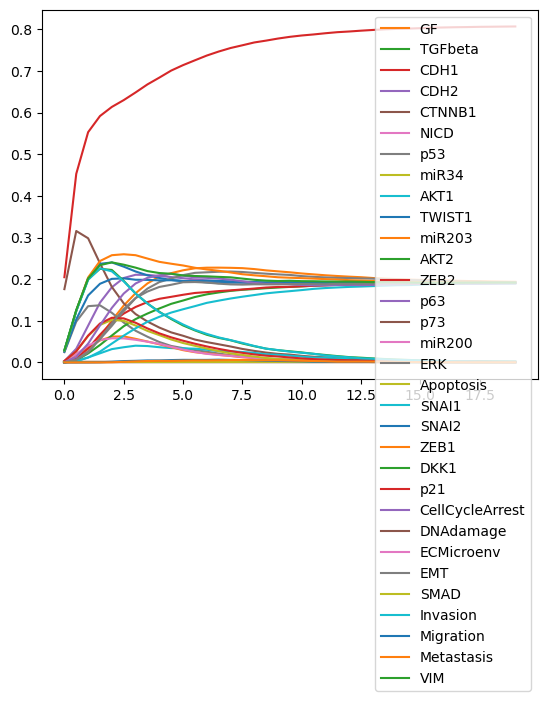

In [3]:
model = maboss.loadBNet('/home/spankaew/Git/BooleanBenchmark/models/Invasion/Invasion_0.bnet')
model.update_parameters(max_time = 20)
simulation = model.run()
simulation.plot_node_trajectory()

In [12]:
# Create blank file to get the results
ensemble_results = {}

path = '/home/spankaew/Git/BooleanBenchmark/models/Invasion/' 
model_list = os.listdir(path)

for model in tqdm(model_list):

    # Load model
    simulations = maboss.loadBNet(path + model)

    # Setup the model initial condition
    ## Put all inputs at random
    for i in simulations.network.names:
        simulations.network.set_istate(i,[0.5,0.5])
        
    # Modify the parameter of the model
    simulations.update_parameters(sample_count = 10000,
                                  thread_count = 15,
                                  max_time = 20,
                                  time_tick = 1)
    simulations.network.set_output(simulations.network.names)

    # Perform simulations
    result = simulations.run()

    # Get matrix
    model_mtx = result.get_nodes_probtraj().copy()

    # Setup cell matrix
    ## Cells
    model_mtx['model_id'] = model.replace('.bnet','')
    ## Timepoint
    model_mtx['timepoint'] = model_mtx.index
    ## Change index
    model_mtx.index = model_mtx.index.map(str)
    model_mtx.index = model + '_' + model_mtx.index

    # Concatenate model results in dictionary
    ensemble_results[model] = model_mtx

  0%|          | 0/1024 [00:00<?, ?it/s]

100%|██████████| 1024/1024 [50:14<00:00,  2.94s/it]


In [13]:
import pandas as pd
simulation_df = pd.concat(ensemble_results.values(), ignore_index = True)
simulation_df.to_csv('/home/spankaew/Git/BooleanBenchmark/tmp/Invasion_simulation_new.csv')

In [4]:
cl_df = pd.read_csv('/home/spankaew/Git/BooleanBenchmark/tmp/Invasion_simulation_new.csv', index_col = 0)
cl_df.index = cl_df.model_id + '_' + [str(f) for f in cl_df.timepoint]
cl_df.index.name = None

In [5]:
adata = sc.AnnData(cl_df.drop(['model_id','timepoint'],axis = 1))
adata.obs['timepoint'] = cl_df['timepoint']
adata.obs['model_id'] = cl_df['model_id']

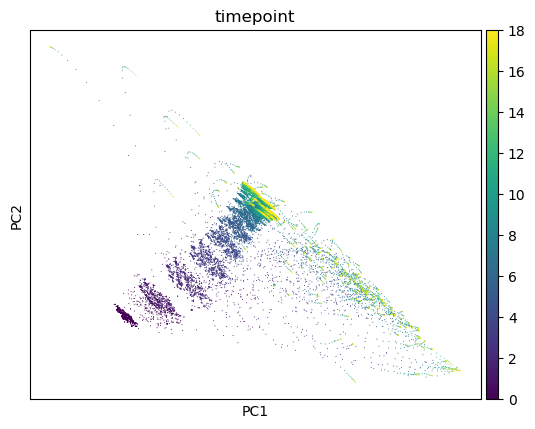

In [6]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color = 'timepoint', size = 2)

/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-

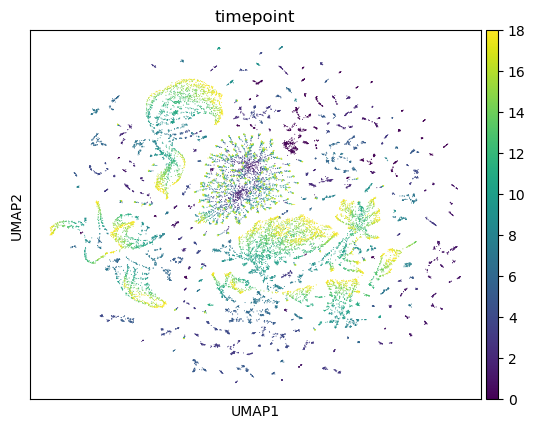

In [114]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color="timepoint",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

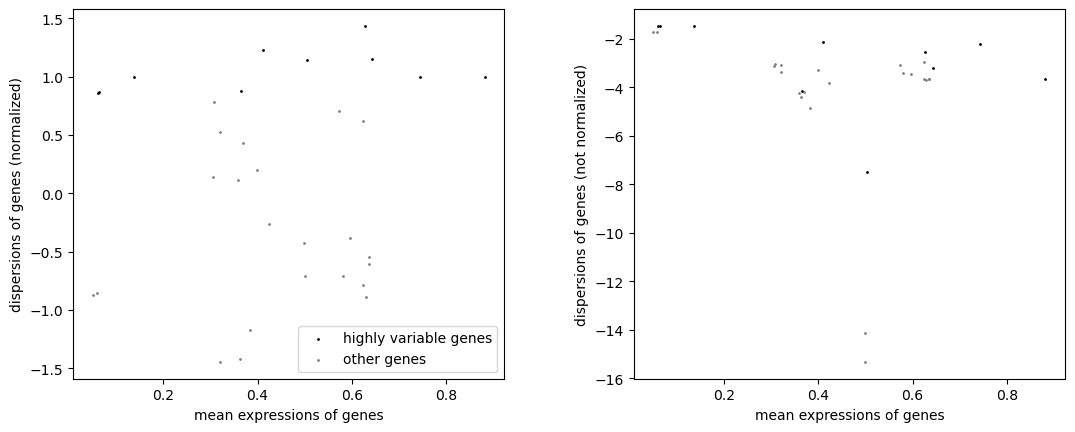

In [7]:
sc.pp.highly_variable_genes(adata, n_top_genes=10)
sc.pl.highly_variable_genes(adata)

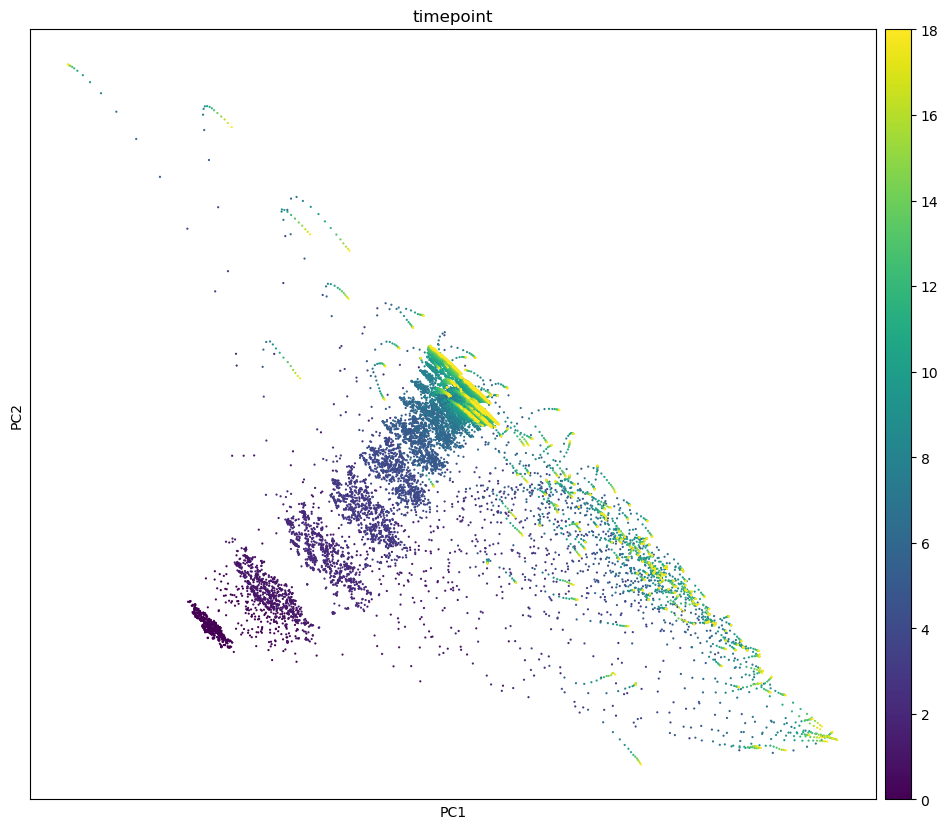

In [8]:
from matplotlib.pyplot import rc_context
with rc_context({"figure.figsize": (12, 10)}):
    sc.pl.pca(adata, color = 'timepoint', size = 10)

In [115]:
pca_mat = [array[:2] for array in adata.obsm['X_pca']]
pca_mat = pd.DataFrame(pca_mat, columns= ['pca1','pca2'])
pca_mat.index = adata.obs.index
pca_mat = pd.concat([pca_mat, adata.obs], axis = 1,ignore_index = False)

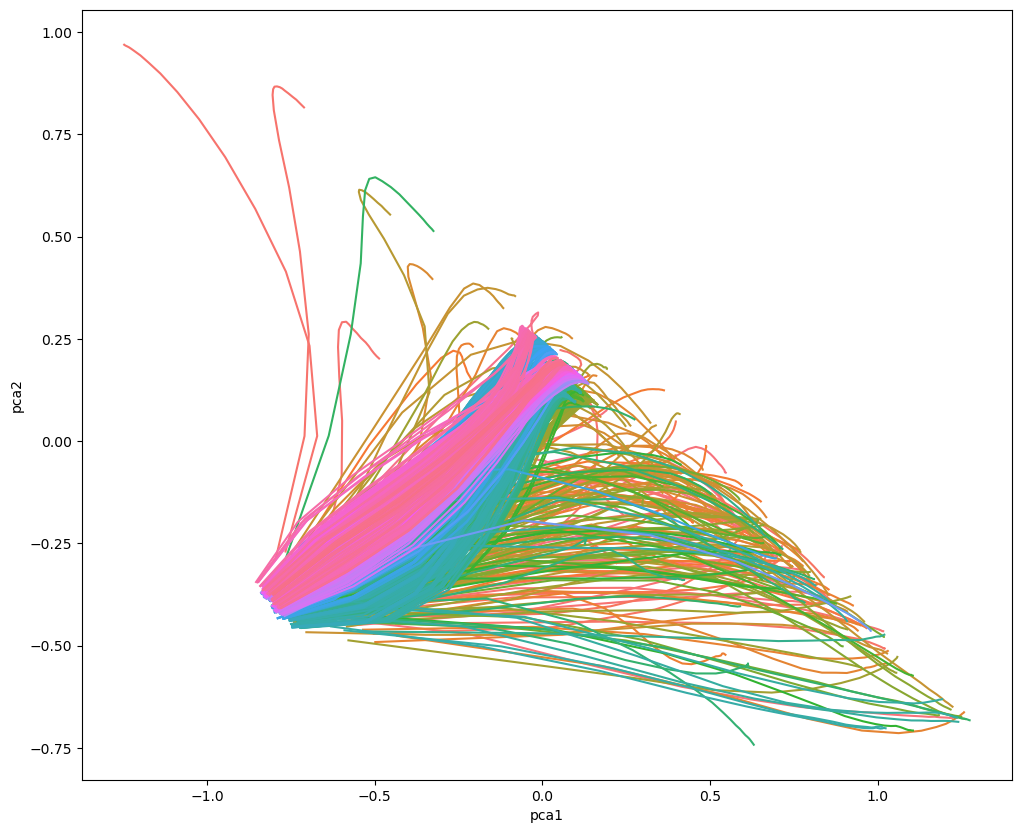

In [11]:
import seaborn as sns
with rc_context({"figure.figsize": (12, 10)}):
    plot = sns.lineplot(data = pca_mat, x = 'pca1',y='pca2',hue = 'model_id', sort = False)
    plot.get_legend().remove()

plt.show()

In [113]:
adata

AnnData object with n_obs × n_vars = 19456 × 32
    obs: 'timepoint', 'model_id'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'hvg'
    obsm: 'X_pca'
    varm: 'PCs'

In [116]:
umap_mat = [array[:2] for array in adata.obsm['X_umap']]
umap_mat = pd.DataFrame(umap_mat, columns= ['umap1','umap2'])
umap_mat.index = adata.obs.index
umap_mat = pd.concat([umap_mat, adata.obs], axis = 1,ignore_index = False)
umap_mat

umap1      umap2  timepoint      model_id
Invasion_532_0.0    5.236312  15.101437        0.0  Invasion_532
Invasion_532_1.0   -4.637139   6.617371        1.0  Invasion_532
Invasion_532_2.0    9.843303  17.624397        2.0  Invasion_532
Invasion_532_3.0    7.039475 -10.601682        3.0  Invasion_532
Invasion_532_4.0  -12.781754  10.379288        4.0  Invasion_532
...                      ...        ...        ...           ...
Invasion_799_14.0   3.311070   3.064426       14.0  Invasion_799
Invasion_799_15.0   3.520934   3.586459       15.0  Invasion_799
Invasion_799_16.0   3.670121   3.969983       16.0  Invasion_799
Invasion_799_17.0   3.928044   4.234212       17.0  Invasion_799
Invasion_799_18.0   3.951045   4.468713       18.0  Invasion_799

[19456 rows x 4 columns]

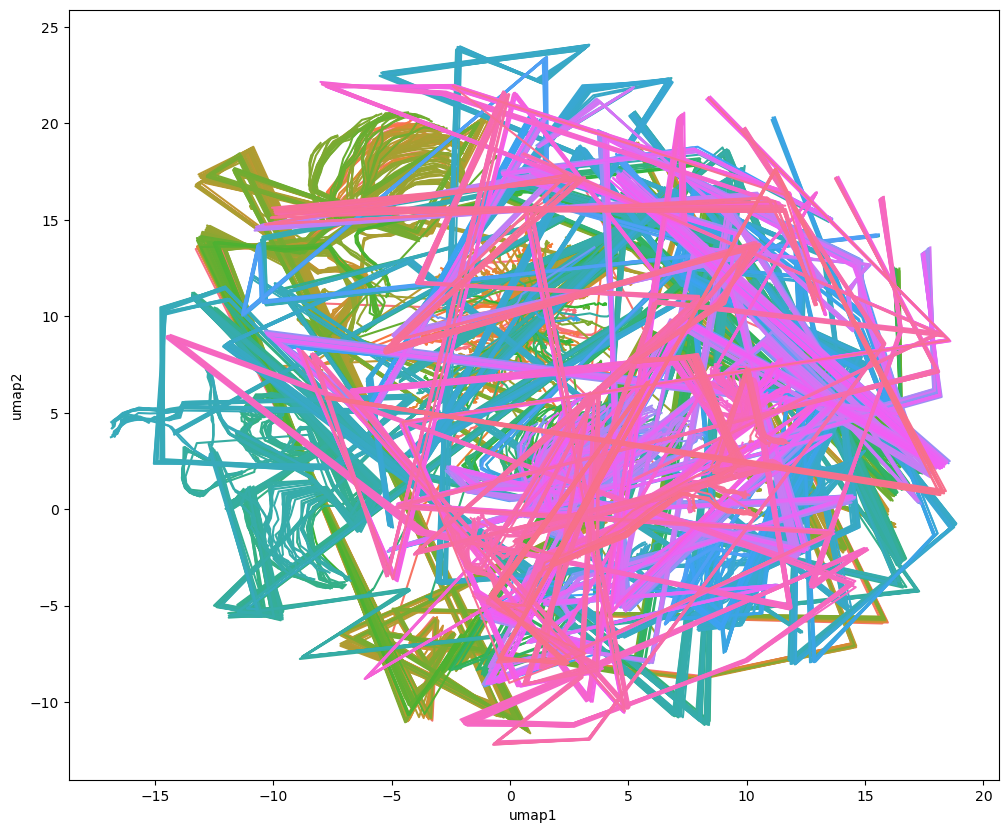

In [117]:
import seaborn as sns
with rc_context({"figure.figsize": (12, 10)}):
    plot = sns.lineplot(data = umap_mat, x = 'umap1',y='umap2',hue = 'model_id', sort = False)
    plot.get_legend().remove()

plt.show()

umap1      umap2  timepoint      model_id
Invasion_532_18.0  -7.630726  -3.285153       18.0  Invasion_532
Invasion_879_18.0  11.463081   5.600034       18.0  Invasion_879
Invasion_718_18.0  -3.417043  10.081062       18.0  Invasion_718
Invasion_988_18.0  -0.676370  -1.973497       18.0  Invasion_988
Invasion_895_18.0  11.679167   6.168101       18.0  Invasion_895
...                      ...        ...        ...           ...
Invasion_427_18.0  -6.996235  -3.920628       18.0  Invasion_427
Invasion_571_18.0 -16.776449   3.838780       18.0  Invasion_571
Invasion_515_18.0  -3.492353   8.094823       18.0  Invasion_515
Invasion_318_18.0  -2.071215  18.429617       18.0  Invasion_318
Invasion_799_18.0   3.951045   4.468713       18.0  Invasion_799

[1024 rows x 4 columns]

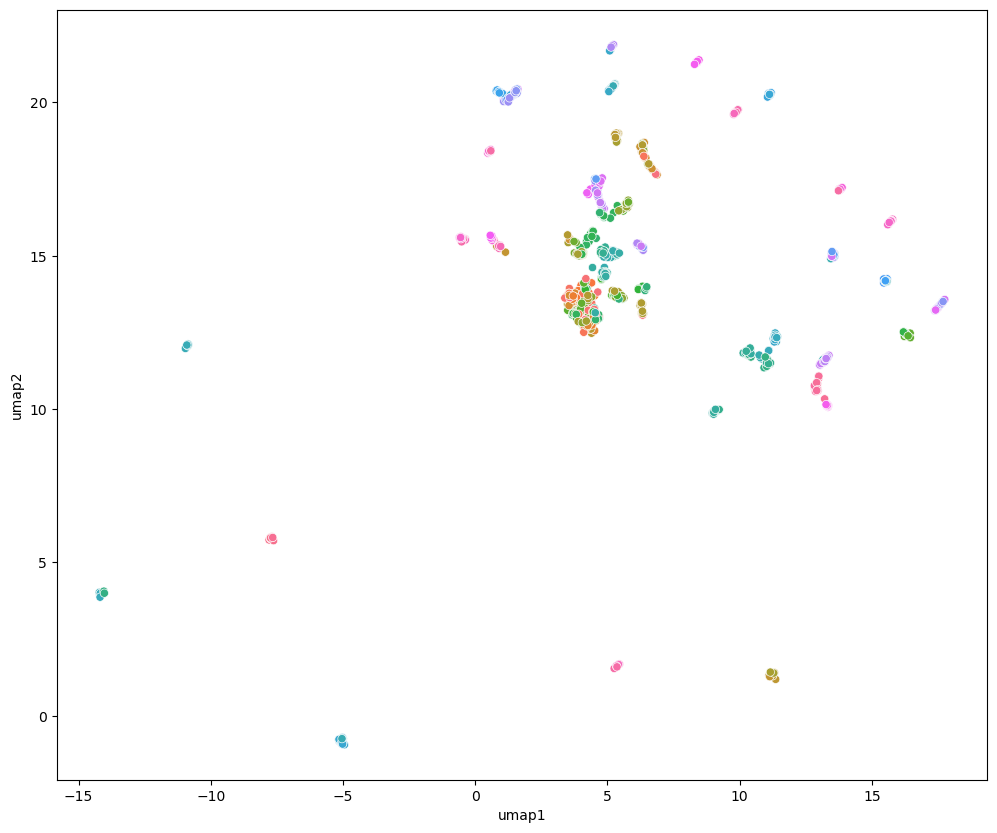

In [145]:

import seaborn as sns
with rc_context({"figure.figsize": (12, 10)}):
    plot = sns.scatterplot(data = umap_mat.loc[umap_mat.timepoint == 0], x = 'umap1',y='umap2',hue = 'model_id')
    plot.get_legend().remove()

plt.show()

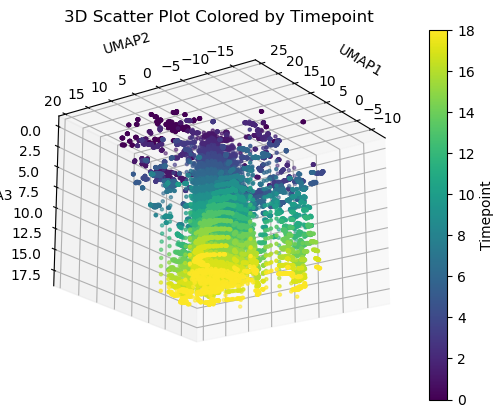

In [122]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with coloring based on 'timepoint'
scatter = ax.scatter(umap_mat['umap2'], 
                     umap_mat['umap1'],
                     umap_mat['timepoint'],
                     c=umap_mat['timepoint'], s = 5)

# Labels and title
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('PCA3')
ax.set_title('3D Scatter Plot Colored by Timepoint')
ax.view_init(elev=20., azim=-35, roll=180)

# Color bar
plt.colorbar(scatter, ax=ax, label='Timepoint')

# Show plot
plt.show()


In [210]:
umap_mat['kmean_cluster'] = umap_mat['model_id'].replace(cluster_dict)
umap_mat

umap1      umap2  timepoint      model_id kmean_cluster
Invasion_532_0.0    5.236312  15.101437        0.0  Invasion_532             6
Invasion_532_1.0   -4.637139   6.617371        1.0  Invasion_532             6
Invasion_532_2.0    9.843303  17.624397        2.0  Invasion_532             6
Invasion_532_3.0    7.039475 -10.601682        3.0  Invasion_532             6
Invasion_532_4.0  -12.781754  10.379288        4.0  Invasion_532             6
...                      ...        ...        ...           ...           ...
Invasion_799_14.0   3.311070   3.064426       14.0  Invasion_799             2
Invasion_799_15.0   3.520934   3.586459       15.0  Invasion_799             2
Invasion_799_16.0   3.670121   3.969983       16.0  Invasion_799             2
Invasion_799_17.0   3.928044   4.234212       17.0  Invasion_799             2
Invasion_799_18.0   3.951045   4.468713       18.0  Invasion_799             2

[19456 rows x 5 columns]

In [212]:
import plotly.graph_objects as go

# Create a trace
trace = go.Scatter3d(
    x=umap_mat['umap1'], 
    y=umap_mat['umap2'], 
    z=umap_mat['timepoint'],
    mode='markers',
    marker=dict(
        size=5,
        color=umap_mat['kmean_cluster'],  # set color to the 'timepoint' values
        #colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)

# Create the 3D plot
fig = go.Figure(data=[trace])

# Customize layout
fig.update_layout(
    title='Interactive 3D Scatter Plot',
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='TIMEPOINT'
    ),
    margin=dict(r=0, b=0, l=0, t=0)  # tight layout
)

# Show the plot
fig.show()


# Trajectory comparison using single variable from PCA

In [125]:
import tslearn
from tslearn.datasets import CachedDatasets
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.preprocessing import TimeSeriesResampler
import numpy


seed = 0
numpy.random.seed(seed)

Euclidean k-means
0.105 --> 0.091 --> 0.086 --> 0.085 --> 0.085 --> 0.085 --> 0.085 --> 0.085 --> 0.085 --> 0.084 --> 0.084 --> 0.084 --> 0.084 --> 0.084 --> 0.084 --> 0.084 --> 0.084 --> 0.084 --> 0.084 --> 0.084 --> 


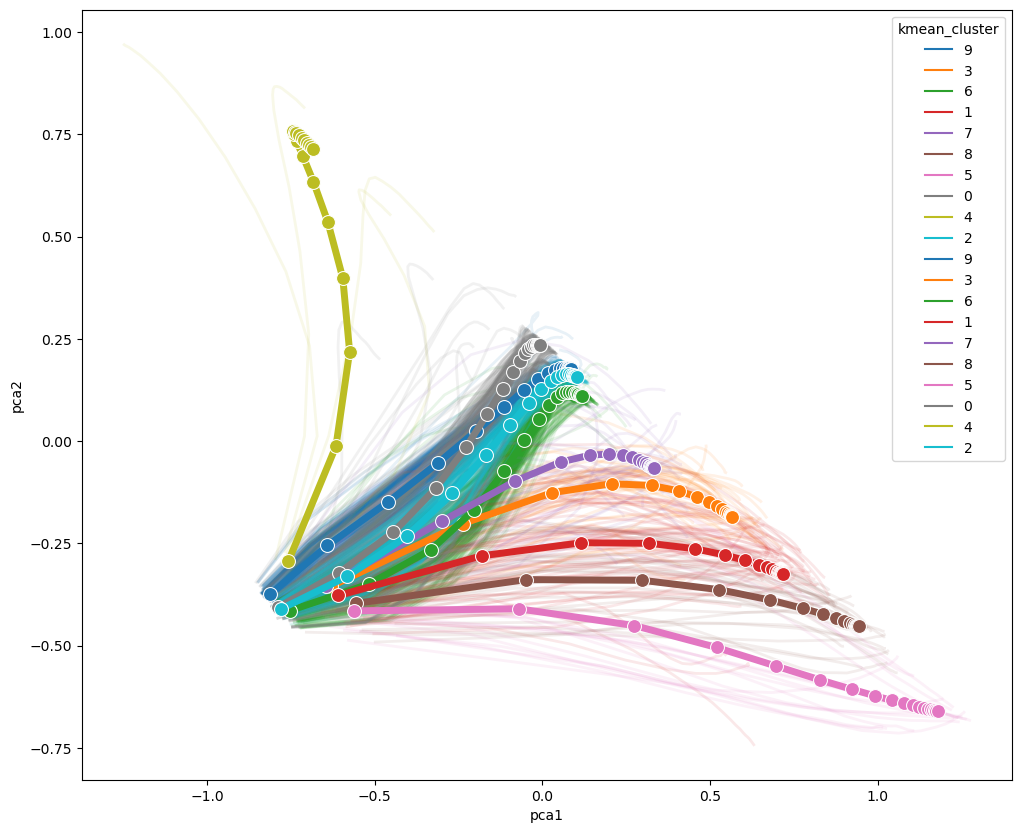

In [126]:
model_name = pca_mat.model_id.cat.categories

model_pca_all = {}
for i in model_name:
    model_pca = pca_mat.loc[pca_mat.model_id == i,['pca1','pca2']].values
    model_pca_all[i] = numpy.array(model_pca)

pca_all_trajectory = numpy.array(list(model_pca_all.values()))

# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=10, verbose=True, random_state=seed)
y_pred = km.fit_predict(pca_all_trajectory)


# Plot the trajectory
cluster_dict = dict(zip(list(model_name),list(y_pred)))
pca_mat['kmean_cluster'] = pca_mat['model_id']
pca_mat['kmean_cluster'] = pca_mat['kmean_cluster'].replace(cluster_dict)

## Calculate the mean position
kmean_cluster = pca_mat.groupby(['timepoint','kmean_cluster'])[['pca1','pca2']].mean()

## Plot with Seaborn
import seaborn as sns
with rc_context({"figure.figsize": (12, 10)}):
    plot = sns.lineplot(data = pca_mat, 
                        x = 'pca1',y='pca2',
                        hue = 'kmean_cluster', units = 'model_id', estimator = None, lw=2, alpha = .1,
                        sort = False)
    plot.get_legend().remove()

    plot2 = sns.lineplot(data = kmean_cluster, 
                        x = 'pca1',y='pca2',
                        hue = 'kmean_cluster',
                        sort = False, marker = 'o', linewidth = 5, markersize = 10)

In [78]:
import itertools
value = list(range(10))
combinations = list(itertools.combinations(value,2))

0

In [131]:
kmean_cluster = pca_mat.groupby(['kmean_cluster','timepoint'])[['pca1','pca2']].mean()

/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



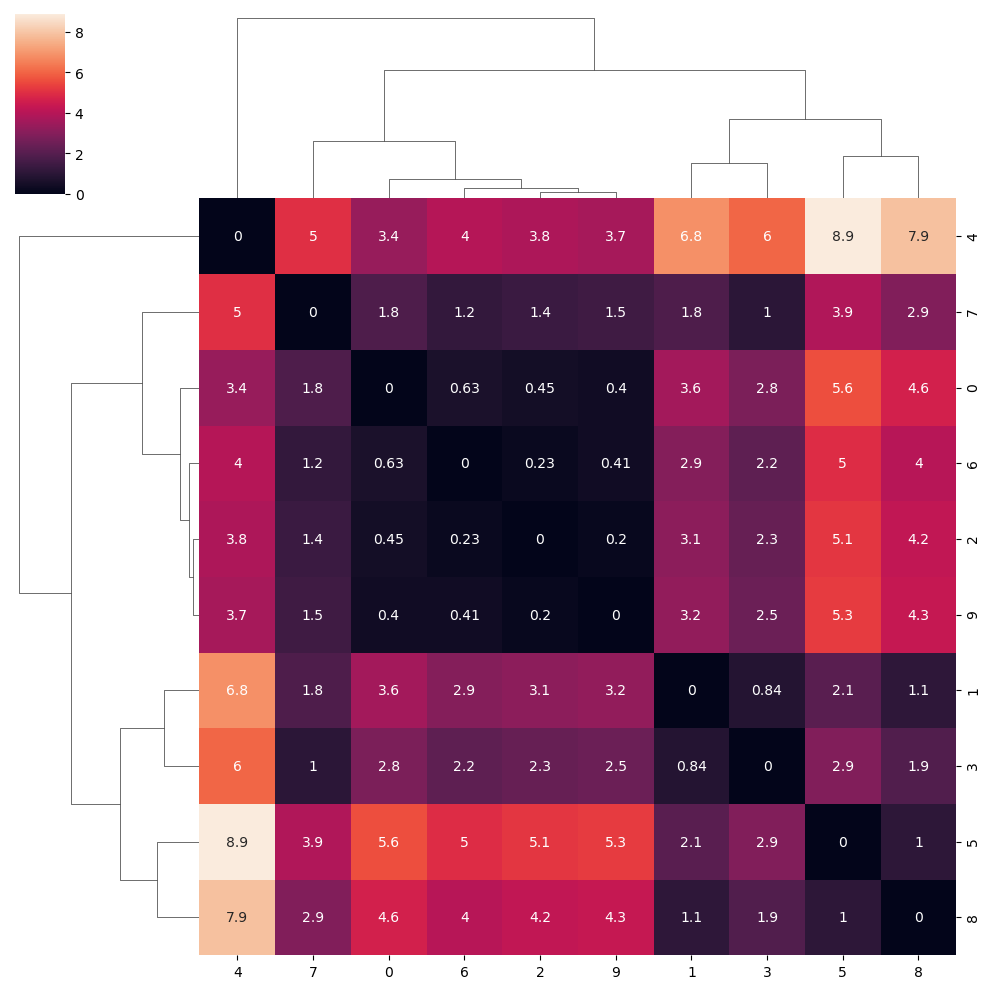

In [164]:
# Calculate Euclidean distances between clusters
distance_matrix = pd.DataFrame()
for i in list(range(10)):
    time_series1 = numpy.array(kmean_cluster.loc[i])
    distance_cluster = []
    for j in list(range(10)):
        time_series2 = numpy.array(kmean_cluster.loc[j])
        distance = numpy.sqrt(numpy.sum((time_series1 - time_series2)**2))
        distance_cluster.append(distance)
    distance_matrix = pd.concat([distance_matrix,pd.DataFrame(distance_cluster)],axis = 1)
distance_matrix.columns = list(range(10))

# Plot Euclidean distance using clustermap
sns.clustermap(distance_matrix, annot=True)

plt.show()

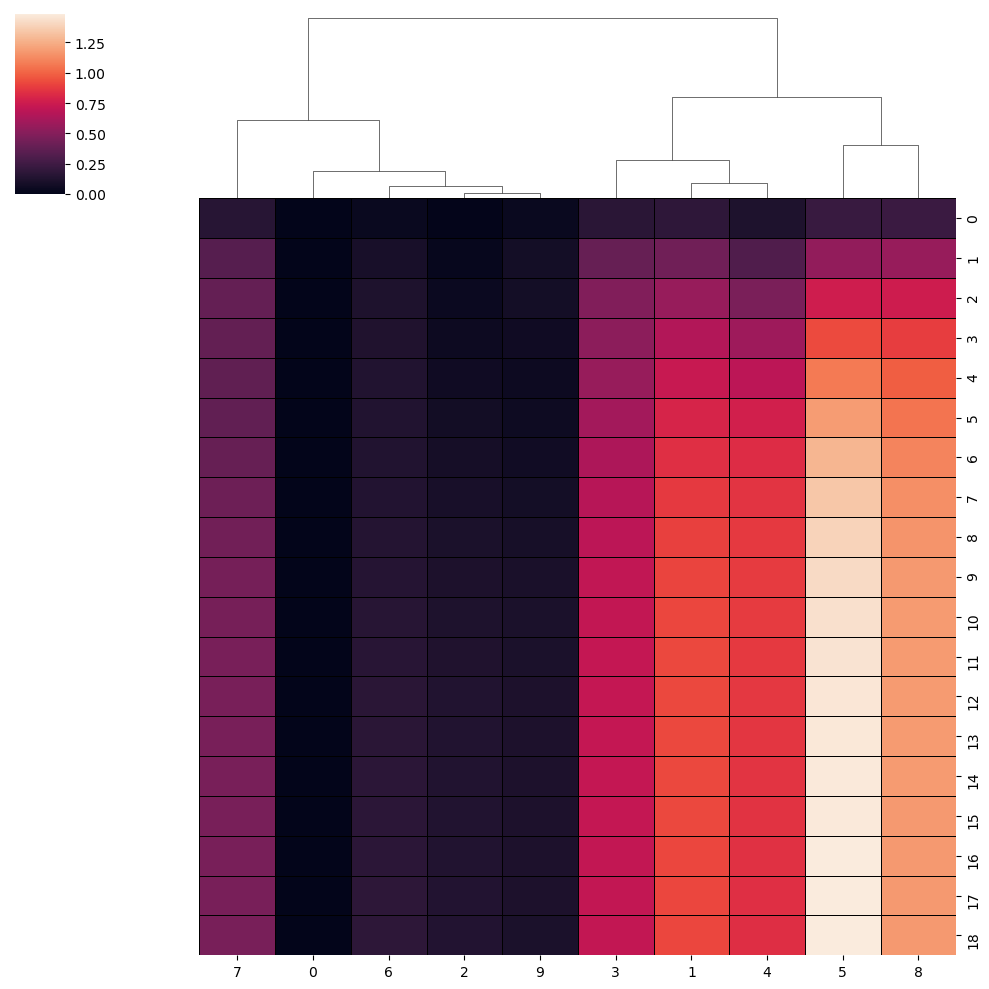

In [136]:
time_series1 = numpy.array(kmean_cluster.loc[0])
cluster_distance = pd.DataFrame()

for i in list(range(10)):
    time_series2 = numpy.array(kmean_cluster.loc[i])

    distance = pd.DataFrame(((time_series1 - time_series2))**2)
    distance = numpy.sqrt(distance[0] + distance[1])
    cluster_distance = pd.concat([cluster_distance,distance], axis = 1)
cluster_distance.columns = list(range(10))

sns.clustermap(cluster_distance, row_cluster=False, linewidth = .5, linecolor = 'black')

In [176]:
test = pd.DataFrame(adata.varm['PCs'][0:2])


0         1         2         3         4         5         6   \
0 -0.019219 -0.026229 -0.007215  0.006835 -0.015222  0.009363 -0.003346   
1 -0.199719 -0.292233 -0.105050  0.089183 -0.062084 -0.045756 -0.023181   

         7         8         9         10        11        12        13  \
0  0.004715 -0.014210  0.012607  0.005669  0.010371 -0.014198 -0.008406   
1  0.014413  0.028054 -0.174546 -0.051868 -0.114653 -0.026393 -0.057440   

         14        15        16        17        18        19        20  \
0  0.009652  0.025801  0.005222  0.017513 -0.044473 -0.016869  0.059639   
1  0.080616 -0.044858  0.177011 -0.145245  0.100477  0.157658  0.227503   

         21        22        23        24        25        26        27  \
0  0.024967 -0.086182 -0.151823 -0.209803 -0.037993  0.249522  0.516138   
1  0.179178 -0.128979 -0.106961  0.690534  0.027378  0.121147 -0.197530   

         28        29        30  
0 -0.659702 -0.387779  0.001442  
1 -0.145013 -0.194430 -0.000711

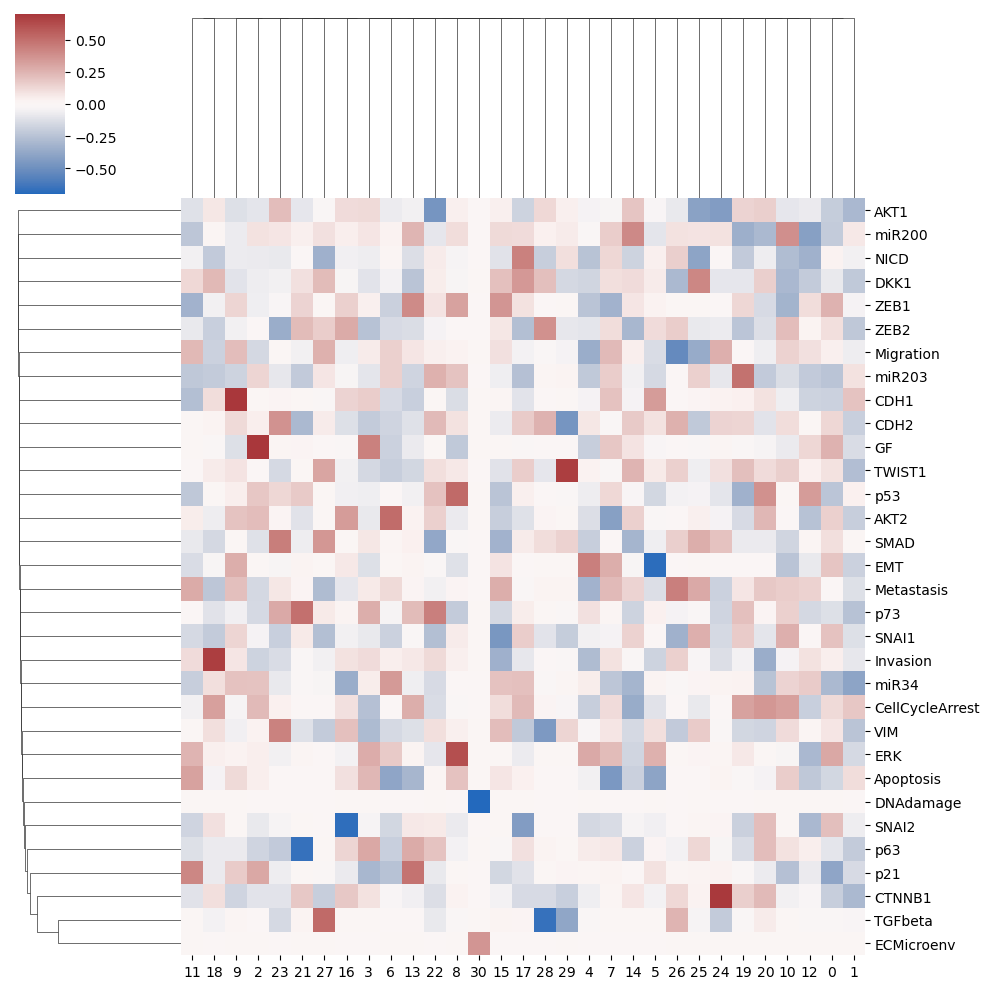

In [182]:
test = pd.DataFrame(adata.varm['PCs'])
test.index = list(adata.var_names)
sns.clustermap(test, cmap = 'vlag', vmax = .7, vmin = -.7)

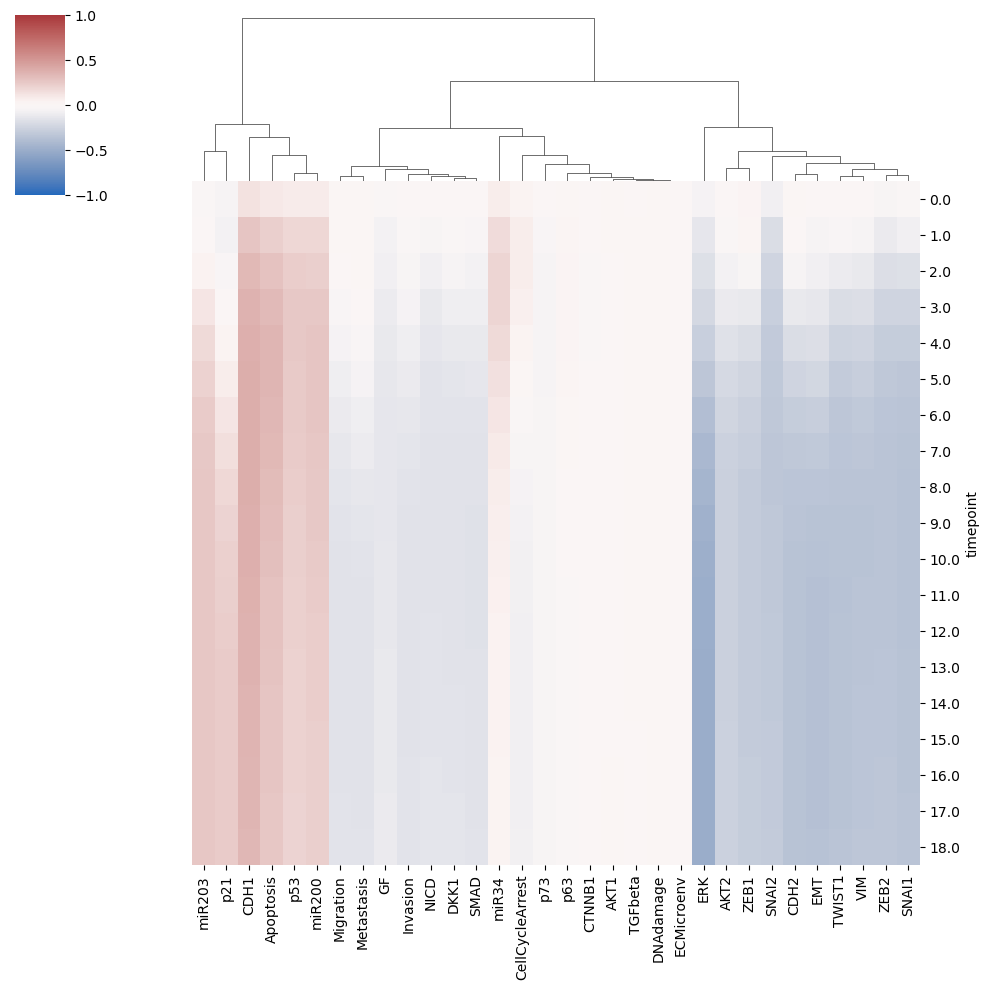

In [208]:
cl_df['kmean_cluster'] = cl_df['model_id']
cl_df['kmean_cluster'] = cl_df['kmean_cluster'].replace(cluster_dict)


test1 = cl_df[cl_df['kmean_cluster']==4]
test1 = test1.groupby(['kmean_cluster','timepoint'])[model.network.names].mean()
test1 = test1.reset_index(level = 'kmean_cluster').drop(columns = ['kmean_cluster'])

test9 = cl_df[cl_df['kmean_cluster']==7]
test9 = test9.groupby(['kmean_cluster','timepoint'])[model.network.names].mean()
test9 = test9.reset_index(level = 'kmean_cluster').drop(columns = ['kmean_cluster'])

test = test1-test9
sns.clustermap(test, row_cluster=False, cmap ='vlag', vmax = 1, vmin = -1)

In [ ]:
import seaborn as sns 

diff_df = sen_df.loc['resistant',:] - sen_df.loc['sensitive',:]
# When plotting the second dataset, we use the previously computed linkage matrix:
cg2 = sns.clustermap(diff_df.transpose(), 
                     row_cluster=True, 
                     col_cluster = False,
                     figsize = (8,22),cmap = 'coolwarm',vmax = 1, vmin = -1)


#plt.savefig('/home/spankaew/pyPROFILE/figures/figure_01/Fig_1D_3.pdf')
plt.show()
#plt.close()

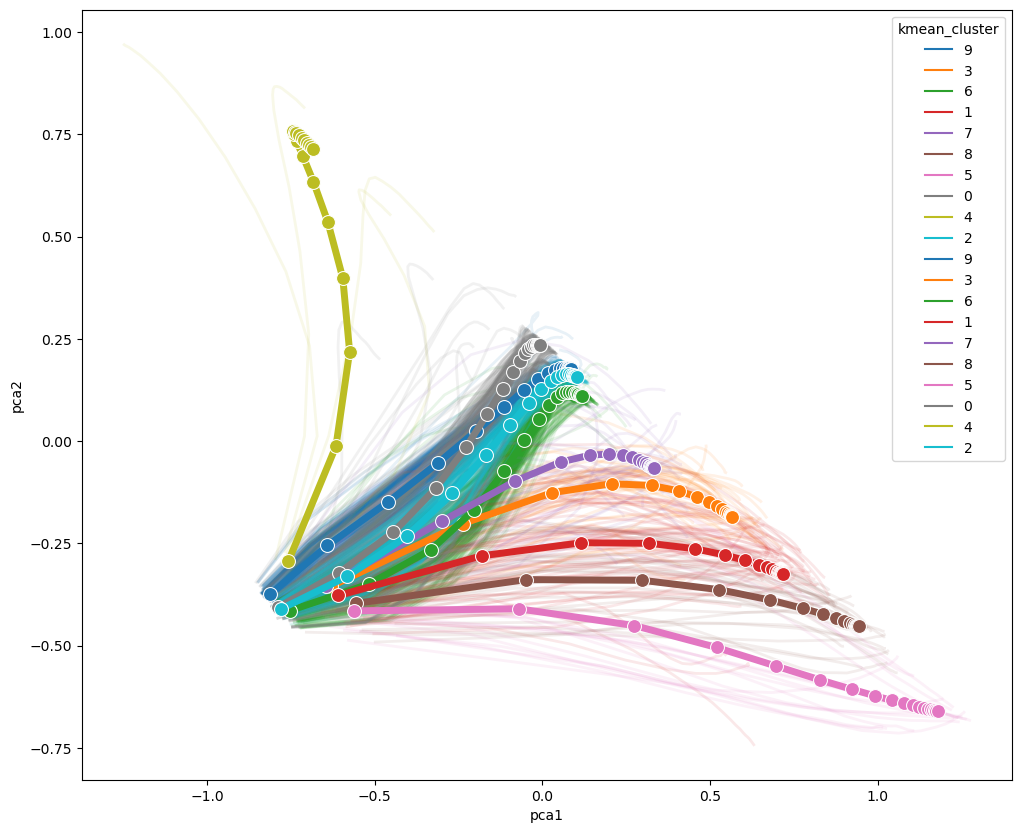

In [162]:
## Plot with Seaborn
import seaborn as sns
with rc_context({"figure.figsize": (12, 10)}):
    plot = sns.lineplot(data = pca_mat, 
                        x = 'pca1',y='pca2',
                        hue = 'kmean_cluster', units = 'model_id', estimator = None, lw=2, alpha = .1,
                        sort = False)
    plot.get_legend().remove()

    plot2 = sns.lineplot(data = kmean_cluster, 
                        x = 'pca1',y='pca2',
                        hue = 'kmean_cluster',
                        sort = False, marker = 'o', linewidth = 5, markersize = 10)

In [92]:
time_series1 = numpy.array(kmean_cluster.loc[combinations[0][0]])
time_series2 = numpy.array(kmean_cluster.loc[combinations[0][1]])
distance = numpy.sqrt(numpy.sum((time_series1 - time_series2)**2))

3.5732815

In [41]:
model_name = pca_mat.model_id.cat.categories

model_pca_all = {}
for i in model_name:
    model_pca = pca_mat.loc[pca_mat.model_id == i,['pca1','pca2']].values
    model_pca_all[i] = numpy.array(model_pca)

pca_all_trajectory = numpy.array(list(model_pca_all.values()))

# Euclidean k-means
print("Euclidean k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=10,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=seed)
y_pred = sdtw_km.fit_predict(pca_all_trajectory)


# Plot the trajectory
cluster_dict = dict(zip(list(model_name),list(y_pred)))
pca_mat['softdtw_cluster'] = pca_mat['model_id']
pca_mat['softdtw_cluster'] = pca_mat['softdtw_cluster'].replace(cluster_dict)

# Calculate the mean position
kmean_cluster = pca_mat.groupby(['timepoint','kmean_cluster'])[['pca1','pca2']].mean()

import seaborn as sns
with rc_context({"figure.figsize": (12, 10)}):
    plot = sns.lineplot(data = pca_mat, 
                        x = 'pca1',y='pca2',
                        hue = 'softdtw_cluster', units = 'model_id', estimator = None, lw=2, alpha = .2,
                        sort = False)
    #plot.get_legend().remove()
    plot = sns.lineplot(data = kmean_cluster, 
                        x = 'pca1',y='pca2',
                        hue = 'kmean_cluster',
                        sort = False, marker = 'o', linewidth = 5, markersize = 10)


plt.show()

Euclidean k-means


KeyboardInterrupt: 

- Find mean PCA postion for each clusters 

- Find mean Euclidean distance at each timestpes between clusters

In [21]:
kmean_dist = pca_mat.groupby(['timepoint','kmean_cluster'])['pca1'].mean()
kmean_dist = pd.DataFrame(kmean_dist).pivot_table(values = 'pca1', index=  'timepoint', columns = 'kmean_cluster')
kmean_dist = 

kmean_cluster         9         3         6         1         7         8  \
timepoint                                                                   
0.0           -0.811310 -0.628888 -0.752504 -0.608179 -0.643923 -0.557204   
1.0           -0.640837 -0.236792 -0.515557 -0.180362 -0.298110 -0.048364   
2.0           -0.461301  0.029892 -0.332011  0.116608 -0.081567  0.298649   
3.0           -0.311572  0.207336 -0.203280  0.319193  0.054233  0.528206   
4.0           -0.196853  0.326851 -0.114142  0.455367  0.141257  0.679196   
5.0           -0.113015  0.407480 -0.053206  0.545761  0.199600  0.776823   
6.0           -0.053606  0.461894 -0.009859  0.605777  0.239359  0.838507   
7.0           -0.012060  0.498008  0.020189  0.645000  0.267286  0.876979   
8.0            0.017610  0.521778  0.042571  0.670051  0.286874  0.901096   
9.0            0.038241  0.537214  0.058623  0.686061  0.300412  0.916160   
10.0           0.052258  0.547317  0.070134  0.696255  0.309663  0.925334   
11.0           0.062389  0.553881  0.080772  0.702931  0.316396  0.931153   
12.0           0.069886  0.558392  0.089394  0.707289  0.321117  0.935088   
13.0           0.075424  0.561292  0.096915  0.710284  0.324581  0.937831   
14.0           0.079335  0.563343  0.102388  0.712438  0.327037  0.939678   
15.0           0.082086  0.564783  0.106951  0.714015  0.328680  0.940996   
16.0           0.084002  0.565798  0.111420  0.715091  0.329992  0.942017   
17.0           0.085492  0.566512  0.114683  0.715945  0.330973  0.942821   
18.0           0.086632  0.567092  0.117222  0.716755  0.331739  0.943415   

kmean_cluster         5         0         4         2  
timepoint                                              
0.0           -0.563009 -0.787635 -0.757462 -0.780017  
1.0           -0.070186 -0.606232 -0.615483 -0.582408  
2.0            0.274873 -0.444944 -0.574737 -0.404808  
3.0            0.519450 -0.318047 -0.595091 -0.268268  
4.0            0.698075 -0.227322 -0.639663 -0.168405  
5.0            0.829273 -0.163815 -0.682904 -0.095147  
6.0            0.924907 -0.118798 -0.714584 -0.041100  
7.0            0.993253 -0.088874 -0.733144 -0.003220  
8.0            1.042430 -0.067700 -0.741677  0.024566  
9.0            1.078042 -0.052903 -0.742935  0.044944  
10.0           1.104387 -0.042254 -0.738597  0.059532  
11.0           1.123887 -0.033698 -0.733200  0.071089  
12.0           1.138477 -0.026905 -0.726152  0.079790  
13.0           1.149593 -0.021314 -0.718248  0.086585  
14.0           1.158463 -0.016849 -0.710591  0.091772  
15.0           1.165248 -0.013442 -0.703053  0.095552  
16.0           1.170705 -0.010396 -0.696013  0.098638  
17.0           1.175206 -0.008119 -0.690169  0.101134  
18.0           1.179042 -0.006359 -0.684169  0.102825

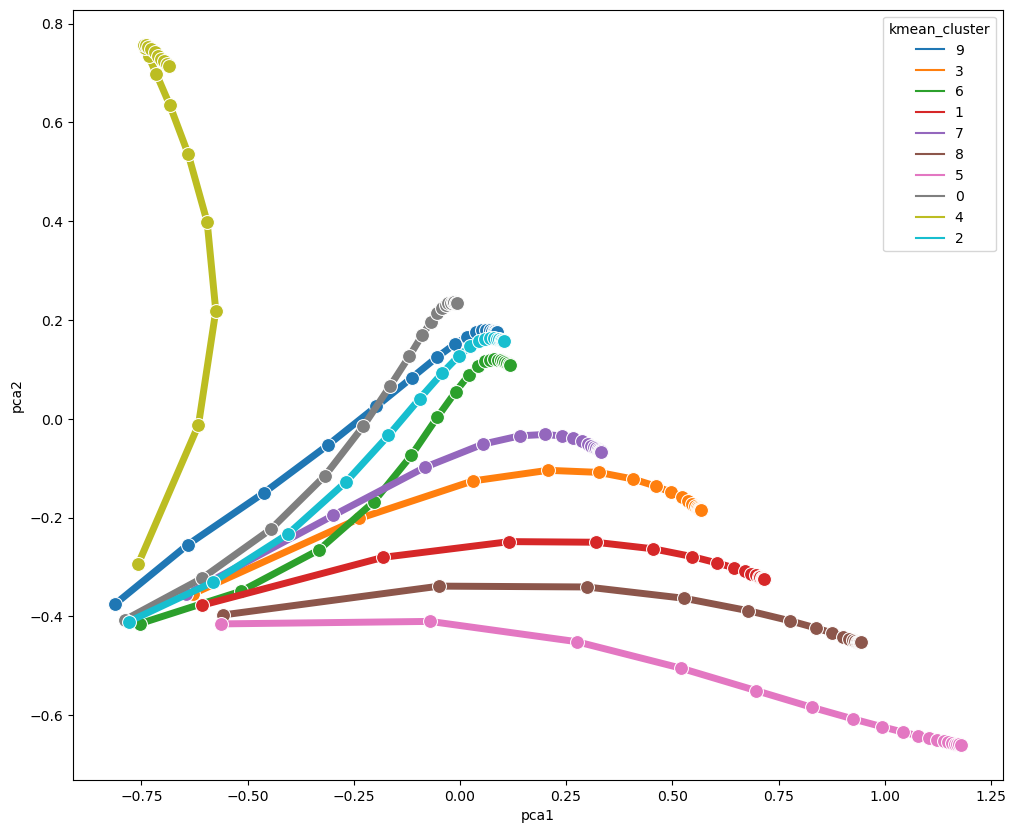

In [40]:
kmean_cluster = pca_mat.groupby(['timepoint','kmean_cluster'])[['pca1','pca2']].mean()
with rc_context({"figure.figsize": (12, 10)}):
    plot = sns.lineplot(data = kmean_cluster, 
                        x = 'pca1',y='pca2',
                        hue = 'kmean_cluster',
                        sort = False, marker = 'o', linewidth = 5, markersize = 10)

In [84]:
test = {}
test['0'] = [1,2,3]
test['1'] = [4,5,6]
test['3'] = [7,8,9]


Euclidean k-means
0.199 --> 0.184 --> 0.184 --> 0.184 --> 0.184 --> 


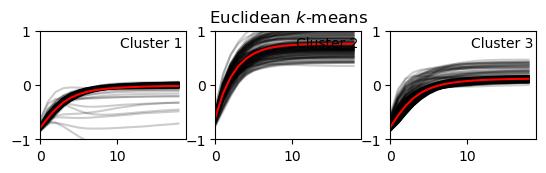

In [86]:
plt.figure()
for yi in range(3):
    plt.subplot(3, 3, yi + 1)
    for xx in pca1_trajectory[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, 19)
    plt.ylim(-1, 1)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

(-1.0, 1.0)

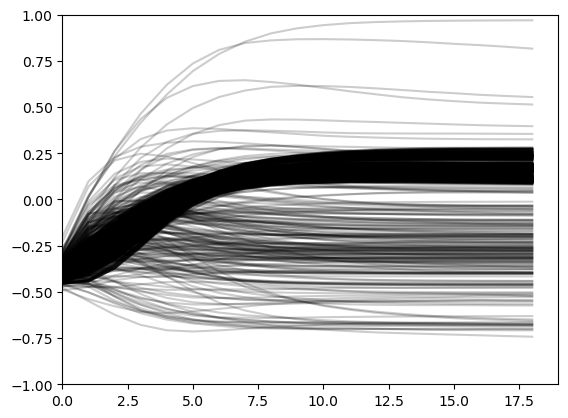

In [65]:
model_name = pca_mat.model_id.cat.categories

for i in model_name:
    model_pca = pca_mat.loc[pca_mat.model_id == i].pca2.values
    plt.plot(model_pca, "k-", alpha=.2)

plt.xlim(0, 19)
plt.ylim(-1, 1)